In [47]:
import boto3
import os
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
from pyspark.sql.functions import mean, stddev, min, max, percentile_approx
from pyspark.sql.window import Window

In [48]:
spark = SparkSession.builder.appName("PySpark Read Parquet").getOrCreate()

In [49]:
work_dir = r"/Users/joseph.mcmilllan/Documents/projects/s4c/slide_deck/SMA_report/data/"

In [50]:
# s3 = boto3.resource("s3")
#
# my_bucket = s3.Bucket("sfc-update-locations-feature-engin-datasets")
#
# for file in my_bucket.objects.filter(
#         Prefix="domain=data_engineering/dataset=job_estimates/version=1.0.3/run_year=2023/run_month=03/run_day=07/"):
#     if file.key.endswith(".parquet"):
#         local_file_name = os.path.join(work_dir, file.key.split("/")[-1])
#
#         #print(f"Downloading{file.key} to {local_file_name}")
#         my_bucket.download_file(file.key, local_file_name)
#         #print(f"Finished {local_file_name}")

In [51]:
df = spark.read.parquet(work_dir)

In [52]:
bnd_df = df.filter(df.locationid == "1-126362857")
bnd_df = bnd_df.orderBy(col("snapshot_date").asc())

In [53]:
quantiles = bnd_df.approxQuantile("estimate_job_count", [0.05, 0.95], 0.0)
print(quantiles)
# Filter out the bottom and top 2.5% of estimate_jobs
bnd_df_filter = bnd_df.filter((bnd_df.estimate_job_count > quantiles[0]) & (bnd_df.estimate_job_count < quantiles[1]))

[71.48963894453904, 221.4716223133867]


In [54]:
num_rows = bnd_df.count()
print("Total number of rows in bnd_df: ", num_rows)

Total number of rows in bnd_df:  72


In [55]:
x_axis = bnd_df.select("snapshot_date").rdd.flatMap(lambda x: x).collect()
y_axis_EJC = bnd_df.select("estimate_job_count").rdd.flatMap(lambda x: x).collect()
y_axis_NOB = bnd_df.select("number_of_beds").rdd.flatMap(lambda x: x).collect()

In [56]:
# Define the window size for the rolling window
window_size = 35

# Define the window based on the estimate_job_count column and the specified window size
rolling_window = Window.orderBy('snapshot_date').rowsBetween(-(window_size - 1), 0)

# Create a new column with the SMA smoothed version of estimate_job_count
bnd_df = bnd_df.withColumn('estimate_job_count_sma', avg(col('estimate_job_count')).over(rolling_window))

In [57]:
y_axis_SMA = bnd_df.select("estimate_job_count_sma").rdd.flatMap(lambda x: x).collect()

23/03/21 10:42:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 1

In [58]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = bnd_df.select('estimate_job_count', 'snapshot_date', 'estimate_job_count_sma' ).toPandas()

23/03/21 10:42:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 1

In [59]:
bnd_df_filter = bnd_df_filter.withColumn('estimate_job_count_sma', avg(col('estimate_job_count')).over(rolling_window))

In [60]:
x_axis_fil = bnd_df_filter.select("snapshot_date").rdd.flatMap(lambda x: x).collect()
y_axis_EJC_fil = bnd_df_filter.select("estimate_job_count").rdd.flatMap(lambda x: x).collect()
y_axis_NOB_fil = bnd_df_filter.select("number_of_beds").rdd.flatMap(lambda x: x).collect()
y_axis_SMA_fil = bnd_df_filter.select("estimate_job_count_sma").rdd.flatMap(lambda x: x).collect()

23/03/21 10:42:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 1

In [61]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df_filter = bnd_df_filter.select('estimate_job_count', 'snapshot_date', 'estimate_job_count_sma' ).toPandas()

23/03/21 10:42:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 10:42:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/21 1

# Simple Moving Average (SMA) and Filtering Report

It has been raised as a point of worry that with the time left on this project that at a location level the model produces "*volatile*" results. The attached report will attempt to explain why these results are the way they are and hope to highlight (with examples) a way to mitigate these worries while also providing some recommendations for future work to improve the machine learning models output. The original praxis for this solution was suggested by Marion Holloway, Data Analyst at Skills for Care.



In [62]:
desc_stats = bnd_df.select(
    mean("estimate_job_count"),
    stddev("estimate_job_count"),
    min("estimate_job_count"),
    max("estimate_job_count"),
    percentile_approx("estimate_job_count", [0.5]).alias("median"))

Below in 1.1, we can see that for locationID "1-126362857" there is a consistent number of beds across the years (102). Our Machine learning model has a pretty consistent value of estimated jobs across the years until 2021. Then from 2021 onwards there are more data points and with that a great deal of volatility in the figures, even going from the lowest value (47) to the highest (226) between 1 data point or 1/2 weeks in real time. This obviously isn't the case, however, it is an issue inherent with the data. The fact that the data has came through consistently in the 7/8 years prior to 2021 and then after 2020/2021 the data reporting rate increase to almost weekly means that the model is looking for changes week to week when previous the time frame was much larger and the change in jobs could be predicted with less volatility at a local level.

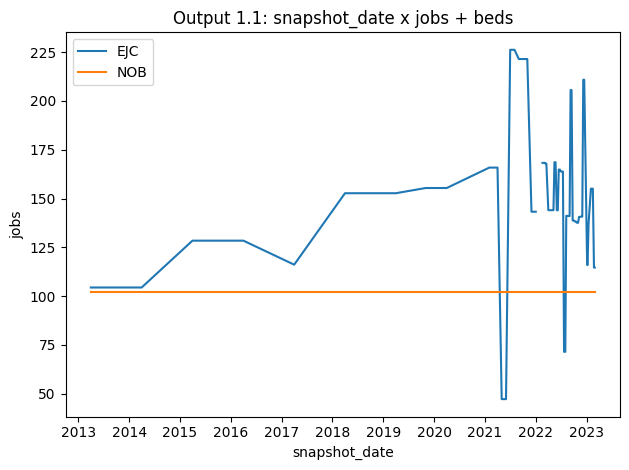

In [63]:
plt.plot(x_axis, y_axis_EJC, label="EJC")
plt.plot(x_axis, y_axis_NOB, label="NOB")
plt.xlabel("snapshot_date")
plt.ylabel("jobs")
plt.title("Output 1.1: snapshot_date x jobs + beds")
plt.legend()
plt.tight_layout()
plt.show()

A way to reduce this volatility is to apply something known as a "Simple Moving Average"(SMA). This is a common and easy way to balance out the power of models that have a very high number of data points at one end. A low level explanation of this process is that it works by adding up X number of values in a data set and dividing the total by the number of values. In our case it divides the total by the total number of rows for this specific location.

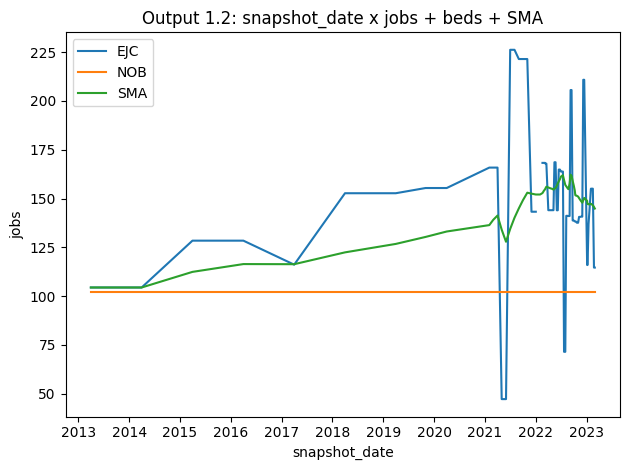

In [64]:
plt.plot(x_axis, y_axis_EJC, label="EJC")
plt.plot(x_axis, y_axis_NOB, label="NOB")
plt.plot(x_axis, y_axis_SMA, label="SMA")
plt.xlabel("snapshot_date")
plt.ylabel("jobs")
plt.title("Output 1.2: snapshot_date x jobs + beds + SMA")
plt.legend()
plt.tight_layout()
plt.show()

We can see in 2.2 that the application of SMA smooths out the volatile figures we are seeing however, overall it still follows the general trend of the data set. This is why we still see volatility (much less pronounced) post 2021 due to the frequency of the data points creating outliers both at the upper and lower range. You can see in 1.3 that these outliers exclusively exist in the data past 2021. Even when we apply the SMA filter to the data (1.4) that there is definitely a more linear relationship however, post 2021 there is still the issue of some outlier data points.

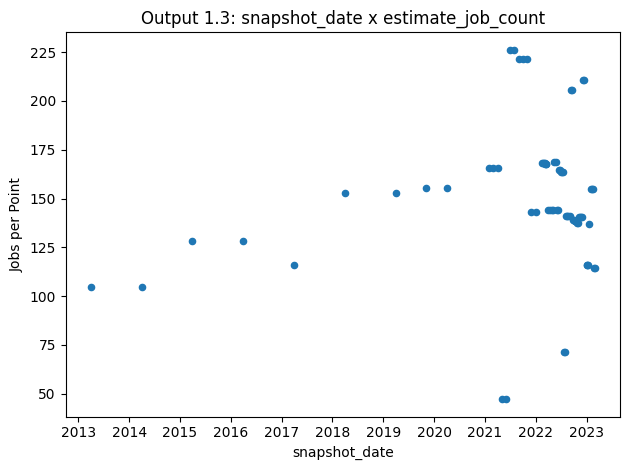

In [65]:
pandas_df.plot.scatter(x='snapshot_date', y='estimate_job_count')
plt.xlabel("snapshot_date")
plt.ylabel("Jobs per Point")
plt.title("Output 1.3: snapshot_date x estimate_job_count")
plt.tight_layout()
plt.show()

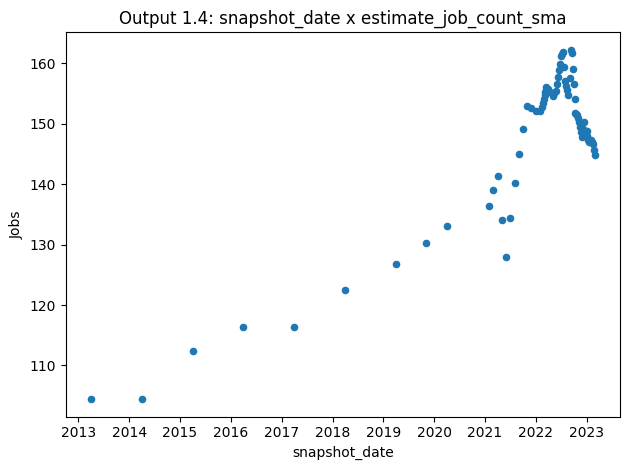

In [66]:
pandas_df.plot.scatter(x='snapshot_date', y='estimate_job_count_sma')
plt.xlabel("snapshot_date")
plt.ylabel("Jobs")
plt.title("Output 1.4: snapshot_date x estimate_job_count_sma")
plt.tight_layout()
plt.show()

Overall SMA does a lot for the volatility of the data, taking the peak from 226 to just over 160, now well within 2 SD of the mean. However, outliers are still powerful causing issues in reporting accurately. This is where filtering out the outliers can provide some fast and easy results. The below chart shows the same data as above with the top and bottom 5% taken out of the dataset before SMA filtering is applied.

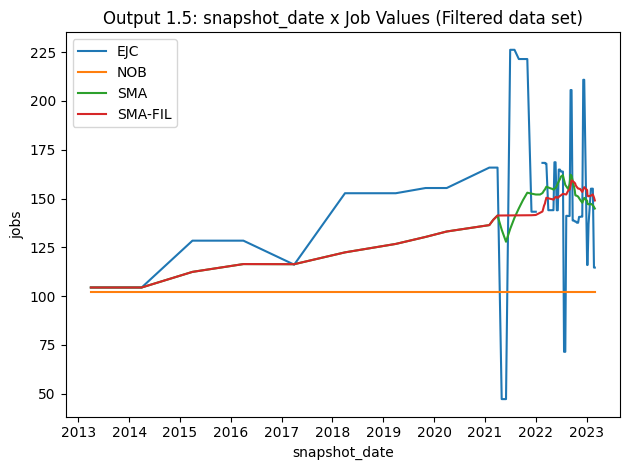

In [67]:
plt.plot(x_axis, y_axis_EJC, label="EJC")
plt.plot(x_axis, y_axis_NOB, label="NOB")
plt.plot(x_axis, y_axis_SMA, label="SMA")
plt.plot(x_axis_fil, y_axis_SMA_fil, label="SMA-FIL")
plt.xlabel("snapshot_date")
plt.ylabel("jobs")
plt.title("Output 1.5: snapshot_date x Job Values (Filtered data set)")
plt.legend()
plt.tight_layout()
plt.show()

We see that removing the top and bottom 5% combined reduces the outlier power dramatically and provides us with a much more reasonable line, with it topping out at just over 150 jobs. Charts 1.6 and 1.7 show the differences in using filtered data alone. The filtered data without the sma filter still has some large outliers which can cause spikes. The SMA and filtering the 5% are working in tandem to address the uptick in reported values.

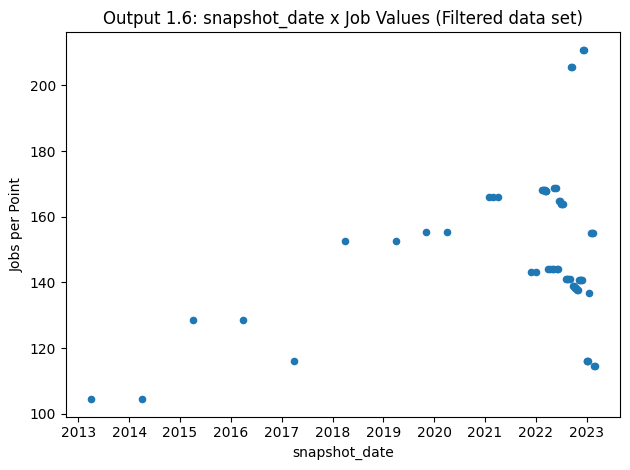

In [68]:
pandas_df_filter.plot.scatter(x='snapshot_date', y='estimate_job_count')
plt.xlabel("snapshot_date")
plt.ylabel("Jobs per Point")
plt.title("Output 1.6: snapshot_date x Job Values (Filtered data set)")
plt.tight_layout()
plt.show()

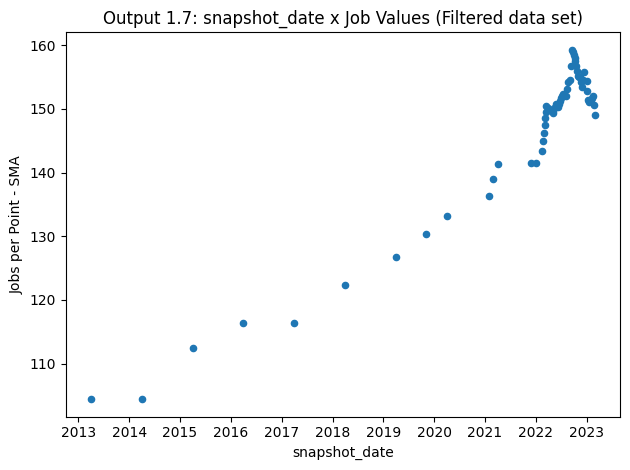

In [69]:
pandas_df_filter.plot.scatter(x='snapshot_date', y='estimate_job_count_sma')
plt.xlabel("snapshot_date")
plt.ylabel("Jobs per Point - SMA")
plt.title("Output 1.7: snapshot_date x Job Values (Filtered data set)")
plt.tight_layout()
plt.show()

This may seem like a lot of effort to reduce volatility in the model however, the volatility is coming from the data not the model. The increased frequency of data points post 2021, plus there is no direct data at a location level in the data provided. The model works so well at a high level due to the data being tailored for high level trends. The lack of location specific data means that in those cases where the job count has high volatility, that machine learning model is simply apply nationwide trends to that location as best it can based on the number of beds. The model has no conceptualisation of what size, or city the care homes are in and thus can only explain so much. The above steps mitigate the issues but more robust data which includes location specific features would lead to a model performing better at this level.

The SMA and filtering are very powerful, however, due to time constraints testing has been done at this one location. Running the same filtering across multiple locations with and without volatile figures would be advised before putting the changes into production. Even with that, it would be advised that these filtering stages are only applied to locations with results that are far beyond what is expected like location 1-126362857. This is suitable low code implementation for the issues raised by S4C and if time allowed a period of 2-3 weeks of testing on larger data and implementation of the method with related unit tests would have been plausible.

# Recommendations for Improving the Model Output

 - Decide on an aggregate date for the data post 2021 reducing the number of data points and thus reducing volatility
 - Finding location new specific data to allow the model to understand local differences:
    - Facility Square footage
    - Number of levels in the facility
    - Is there a number of staff that triggers certain onsite teams e.g. finance or HR on sites with more than 100 care staff
    - Do they have a car park?
 - Is there data you currently have that can establish patterns at a local level already for example facility post code